In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import matplotlib.pyplot as plt
import math
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/youtube-channels-100000/channels.csv
/kaggle/input/youtube-new/GBvideos.csv
/kaggle/input/youtube-new/MXvideos.csv
/kaggle/input/youtube-new/KRvideos.csv
/kaggle/input/youtube-new/MX_category_id.json
/kaggle/input/youtube-new/GB_category_id.json
/kaggle/input/youtube-new/US_category_id.json
/kaggle/input/youtube-new/IN_category_id.json
/kaggle/input/youtube-new/DEvideos.csv
/kaggle/input/youtube-new/KR_category_id.json
/kaggle/input/youtube-new/RU_category_id.json
/kaggle/input/youtube-new/FRvideos.csv
/kaggle/input/youtube-new/USvideos.csv
/kaggle/input/youtube-new/INvideos.csv
/kaggle/input/youtube-new/RUvideos.csv
/kaggle/input/youtube-new/CA_category_id.json
/kaggle/input/youtube-new/DE_category_id.json
/kaggle/input/youtube-new/JP_category_id.json
/kaggle/input/youtube-new/JPvideos.csv
/kaggle/input/youtube-new/FR_category_id.json
/kaggle/input/youtube-new/CAvideos.csv


In [28]:
ca_data = pd.read_csv('/kaggle/input/youtube-new/CAvideos.csv')
ca_data.head()
ca_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40881 entries, 0 to 40880
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40881 non-null  object
 1   trending_date           40881 non-null  object
 2   title                   40881 non-null  object
 3   channel_title           40881 non-null  object
 4   category_id             40881 non-null  int64 
 5   publish_time            40881 non-null  object
 6   tags                    40881 non-null  object
 7   views                   40881 non-null  int64 
 8   likes                   40881 non-null  int64 
 9   dislikes                40881 non-null  int64 
 10  comment_count           40881 non-null  int64 
 11  thumbnail_link          40881 non-null  object
 12  comments_disabled       40881 non-null  bool  
 13  ratings_disabled        40881 non-null  bool  
 14  video_error_or_removed  40881 non-null  bool  
 15  de

In [29]:
channel_dataset = pd.read_csv('../input/youtube-channels-100000/channels.csv')
channel_dataset.head()
channel_dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104752 entries, 0 to 104751
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   category_id    104752 non-null  int64  
 1   category_name  104752 non-null  object 
 2   channel_id     104752 non-null  object 
 3   country        70624 non-null   object 
 4   description    93423 non-null   object 
 5   followers      104752 non-null  int64  
 6   join_date      104751 non-null  object 
 7   location       0 non-null       float64
 8   picture_url    104752 non-null  object 
 9   profile_url    104752 non-null  object 
 10  title          104744 non-null  object 
 11  trailer_title  104671 non-null  object 
 12  trailer_url    104752 non-null  object 
 13  videos         104752 non-null  int64  
dtypes: float64(1), int64(3), object(10)
memory usage: 11.2+ MB


In [30]:
channel_dataset = channel_dataset[['category_id','category_name', 'followers', 'videos', 'title', 'country']]
channel_dataset = channel_dataset.rename(columns={'title':'channel_title', 'category_name': 'channel_category_name', 'category_id': 'channel_category_id'})
channel_dataset = channel_dataset.dropna(subset=['followers'])

In [31]:
ca_data = ca_data.merge(channel_dataset, on='channel_title', how='left')
print('missing values percentage', ca_data['followers'].isnull().sum()/len(ca_data) * 100)
ca_data = ca_data.dropna(subset=['followers'])

missing values percentage 26.012532110532256


In [32]:
ca_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30818 entries, 0 to 41651
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   video_id                30818 non-null  object 
 1   trending_date           30818 non-null  object 
 2   title                   30818 non-null  object 
 3   channel_title           30818 non-null  object 
 4   category_id             30818 non-null  int64  
 5   publish_time            30818 non-null  object 
 6   tags                    30818 non-null  object 
 7   views                   30818 non-null  int64  
 8   likes                   30818 non-null  int64  
 9   dislikes                30818 non-null  int64  
 10  comment_count           30818 non-null  int64  
 11  thumbnail_link          30818 non-null  object 
 12  comments_disabled       30818 non-null  bool   
 13  ratings_disabled        30818 non-null  bool   
 14  video_error_or_removed  30818 non-null

In [33]:
with open('/kaggle/input/youtube-new/CA_category_id.json') as f:
    categories = json.load(f)
categories_map = {}
for category in categories['items']:
    categories_map[int(category['id'])] = category['snippet']['title']
ca_data['category_id'] = ca_data['category_id'].map(categories_map)
ca_data.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,channel_category_id,channel_category_name,followers,videos,country
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,Music,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,...,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,10.0,Music,26572348.0,82.0,NaN
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,Comedy,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,...,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...,23.0,Comedy,7037488.0,252.0,United States
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,Comedy,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,...,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,10.0,Music,5577263.0,86.0,United States
3,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,Entertainment,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,...,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,24.0,Entertainment,21302893.0,346.0,NaN
4,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,Music,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,...,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...,10.0,Music,35343953.0,122.0,Great-Britain


In [34]:
print('Views stats', ca_data['views'].describe())
print('Comment stats', ca_data['comment_count'].describe())
print('Like stats', ca_data['likes'].describe())
ca_data.isnull().sum()
ca_data = ca_data.dropna(subset=['category_id'])
print('info', ca_data.info())

Views stats count    3.081800e+04
mean     1.308419e+06
std      3.707159e+06
min      1.000000e+03
25%      1.741255e+05
50%      4.348935e+05
75%      1.103853e+06
max      1.378431e+08
Name: views, dtype: float64
Comment stats count     30818.000000
mean       5788.966253
std       20062.974865
min           0.000000
25%         590.000000
50%        1655.000000
75%        4529.000000
max      827755.000000
Name: comment_count, dtype: float64
Like stats count    3.081800e+04
mean     4.494625e+04
std      1.305947e+05
min      0.000000e+00
25%      3.619500e+03
50%      1.206000e+04
75%      3.434100e+04
max      3.037318e+06
Name: likes, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30791 entries, 0 to 41651
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   video_id                30791 non-null  object 
 1   trending_date           30791 non-null  object 
 2   title    

In [35]:
ca_data['description'] = ca_data['description'].fillna(value='None',inplace=True)

In [36]:
ca_data['publish_time'] = pd.to_datetime(ca_data['publish_time'], format = '%Y-%m-%dT%H:%M:%S.%fZ')
ca_data['publish_month'] = ca_data['publish_time'].dt.month
ca_data['publish_hour'] = ca_data['publish_time'].dt.hour

In [37]:
ca_data['like_percentage'] = (ca_data['likes'] / ca_data['views']) * 100
ca_data['dislike_percentage'] = (ca_data['dislikes']/ca_data['views']) * 100
ca_data.loc[ca_data['likes'] >= ca_data['dislikes'],'more_likes'] = 1
ca_data.loc[ca_data['likes'] < ca_data['dislikes'],'more_likes'] = 0


In [38]:
def get_title_length(title):
    return len(title)
def get_number_of_tags(string_of_tags):
    tags = string_of_tags.split('|')
    tags_no_empty_strings = []
    for tag in tags:
        if tag != '':
            tags_no_empty_strings.append(tag)
    return len(tags_no_empty_strings)
def contains_all_caps_word(title):
    words = title.split(' ')
    words_in_capital = [word for word in words if word.isupper()]
    return 1 if len(words_in_capital) >=3 else 0
    

ca_data['title_length'] = ca_data.apply(lambda row: get_title_length(row['title']), axis=1)
ca_data['number_of_tags'] = ca_data.apply(lambda row: get_number_of_tags(row['tags']), axis=1)
ca_data['title_contains_all_caps_word'] = ca_data.apply(lambda row: contains_all_caps_word(row['title']), axis=1)

# Visualizations

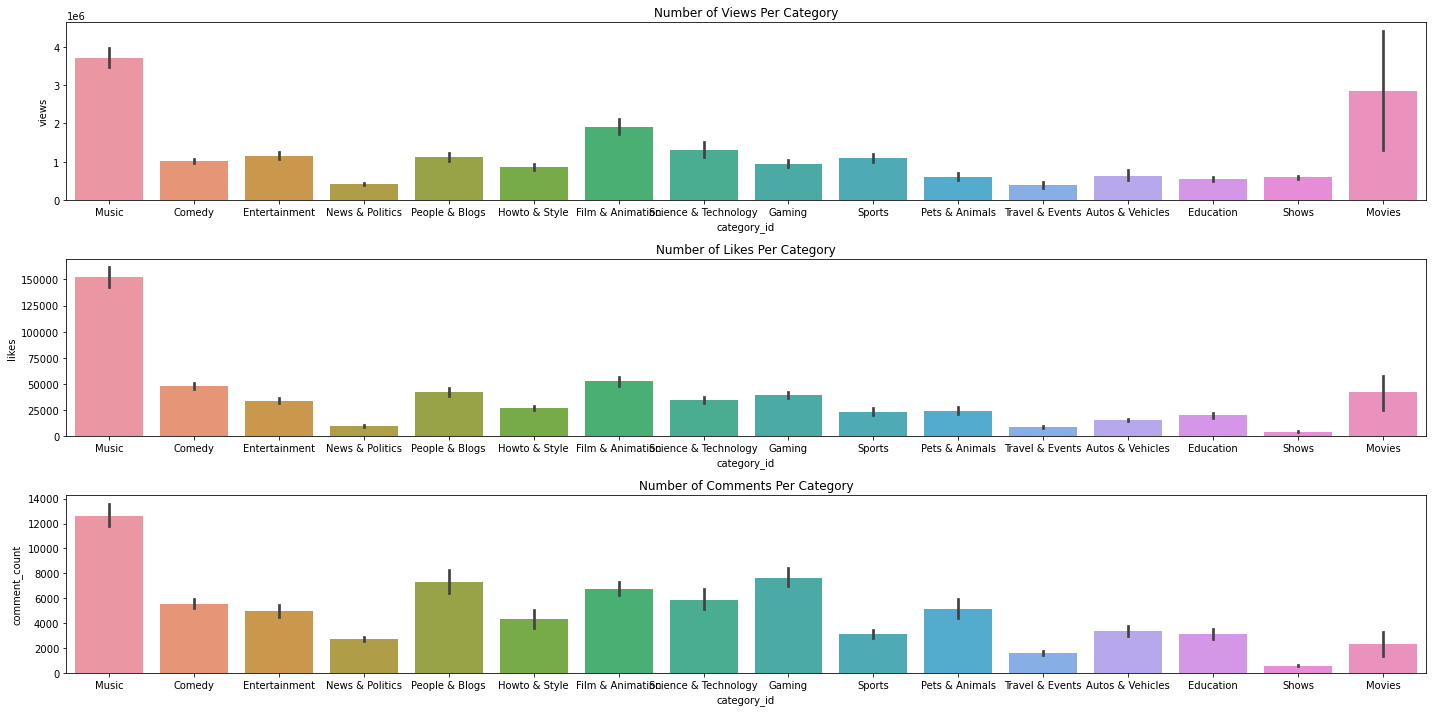

In [39]:
f,ax = plt.subplots(3,1, figsize=(20,10))
views_by_categories_plot = sns.barplot(x=ca_data['category_id'], y=ca_data['views'], ax=ax[0])
views_by_categories_plot.set_title('Number of Views Per Category') 
likes_by_categories_plot = sns.barplot(x=ca_data['category_id'], y=ca_data['likes'], ax=ax[1])
likes_by_categories_plot.set_title('Number of Likes Per Category')     
comment_count_by_categories_plot = sns.barplot(x=ca_data['category_id'], y=ca_data['comment_count'], ax=ax[2])
comment_count_by_categories_plot.set_title('Number of Comments Per Category')  
plt.tight_layout()

Text(0.5, 1.0, 'Correlation Heatmap')

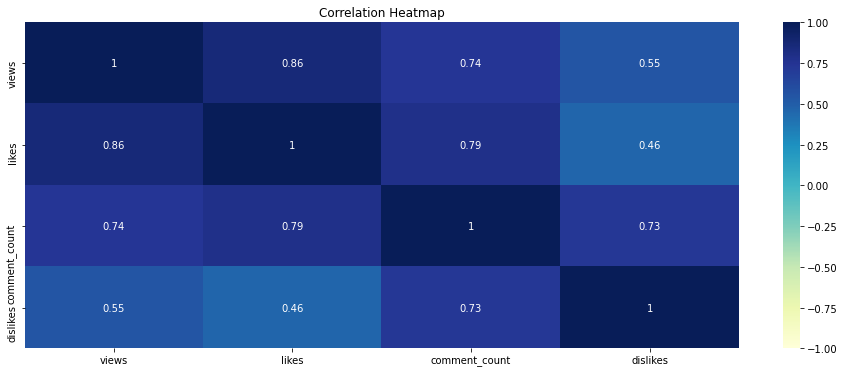

In [40]:
plt.figure(figsize=(16,6))
correlation_matrix_heatmap = sns.heatmap(ca_data[['views', 'likes', 'comment_count','dislikes']].corr(),vmin=-1,vmax=1, cmap='YlGnBu', annot=True)
correlation_matrix_heatmap.set_title('Correlation Heatmap')

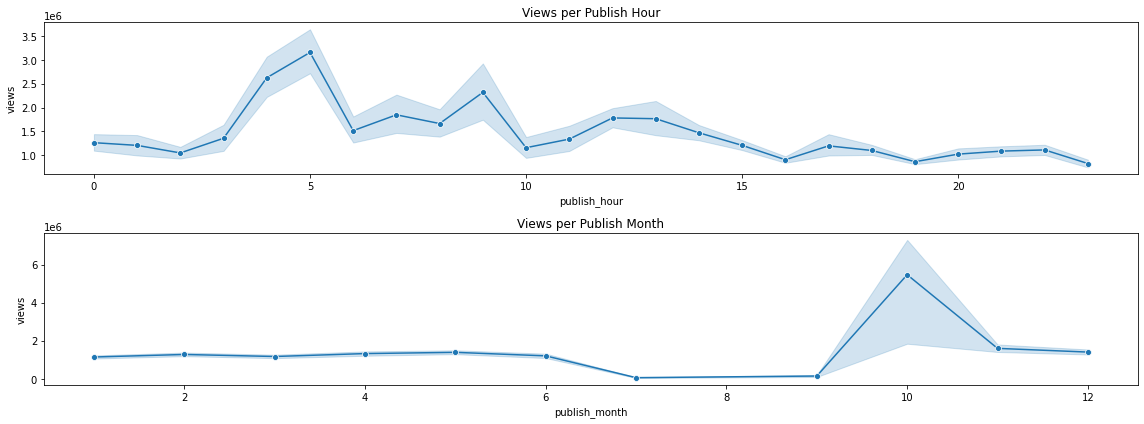

In [41]:
f,ax = plt.subplots(2,1, figsize=(16,6))
views_by_hour = sns.lineplot(x=ca_data['publish_hour'], y=ca_data['views'],data=ca_data,marker='o', ax=ax[0])
views_by_hour.set_title('Views per Publish Hour')
views_by_month= sns.lineplot(x=ca_data['publish_month'], y=ca_data['views'],data=ca_data,marker='o', ax=ax[1])
views_by_month.set_title('Views per Publish Month')
plt.tight_layout()

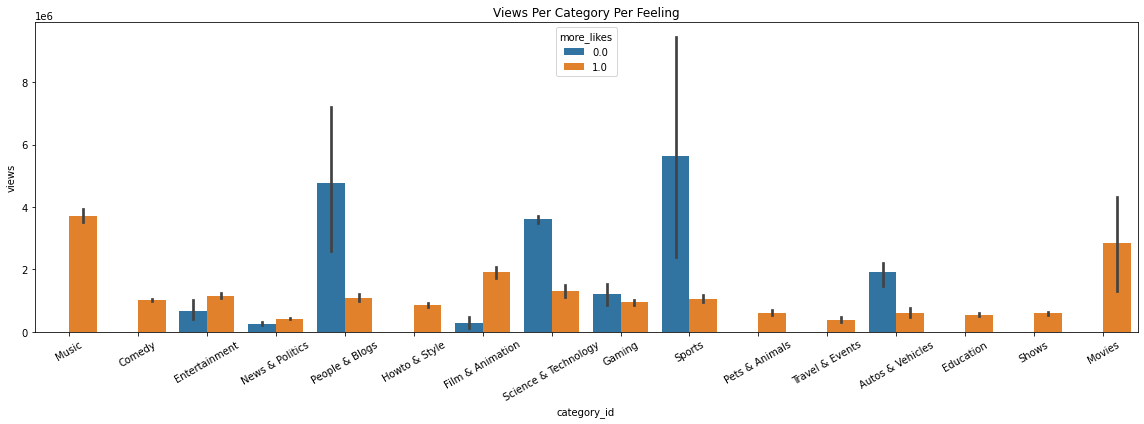

In [42]:
plt.figure(figsize=(16,6))
feeling_barplot = sns.barplot(x=ca_data['category_id'], y=ca_data['views'], hue=ca_data['more_likes'], data=ca_data)
feeling_barplot.set_xticklabels(feeling_barplot.get_xticklabels(),rotation=30)
feeling_barplot.set_title('Views Per Category Per Feeling')
plt.tight_layout()

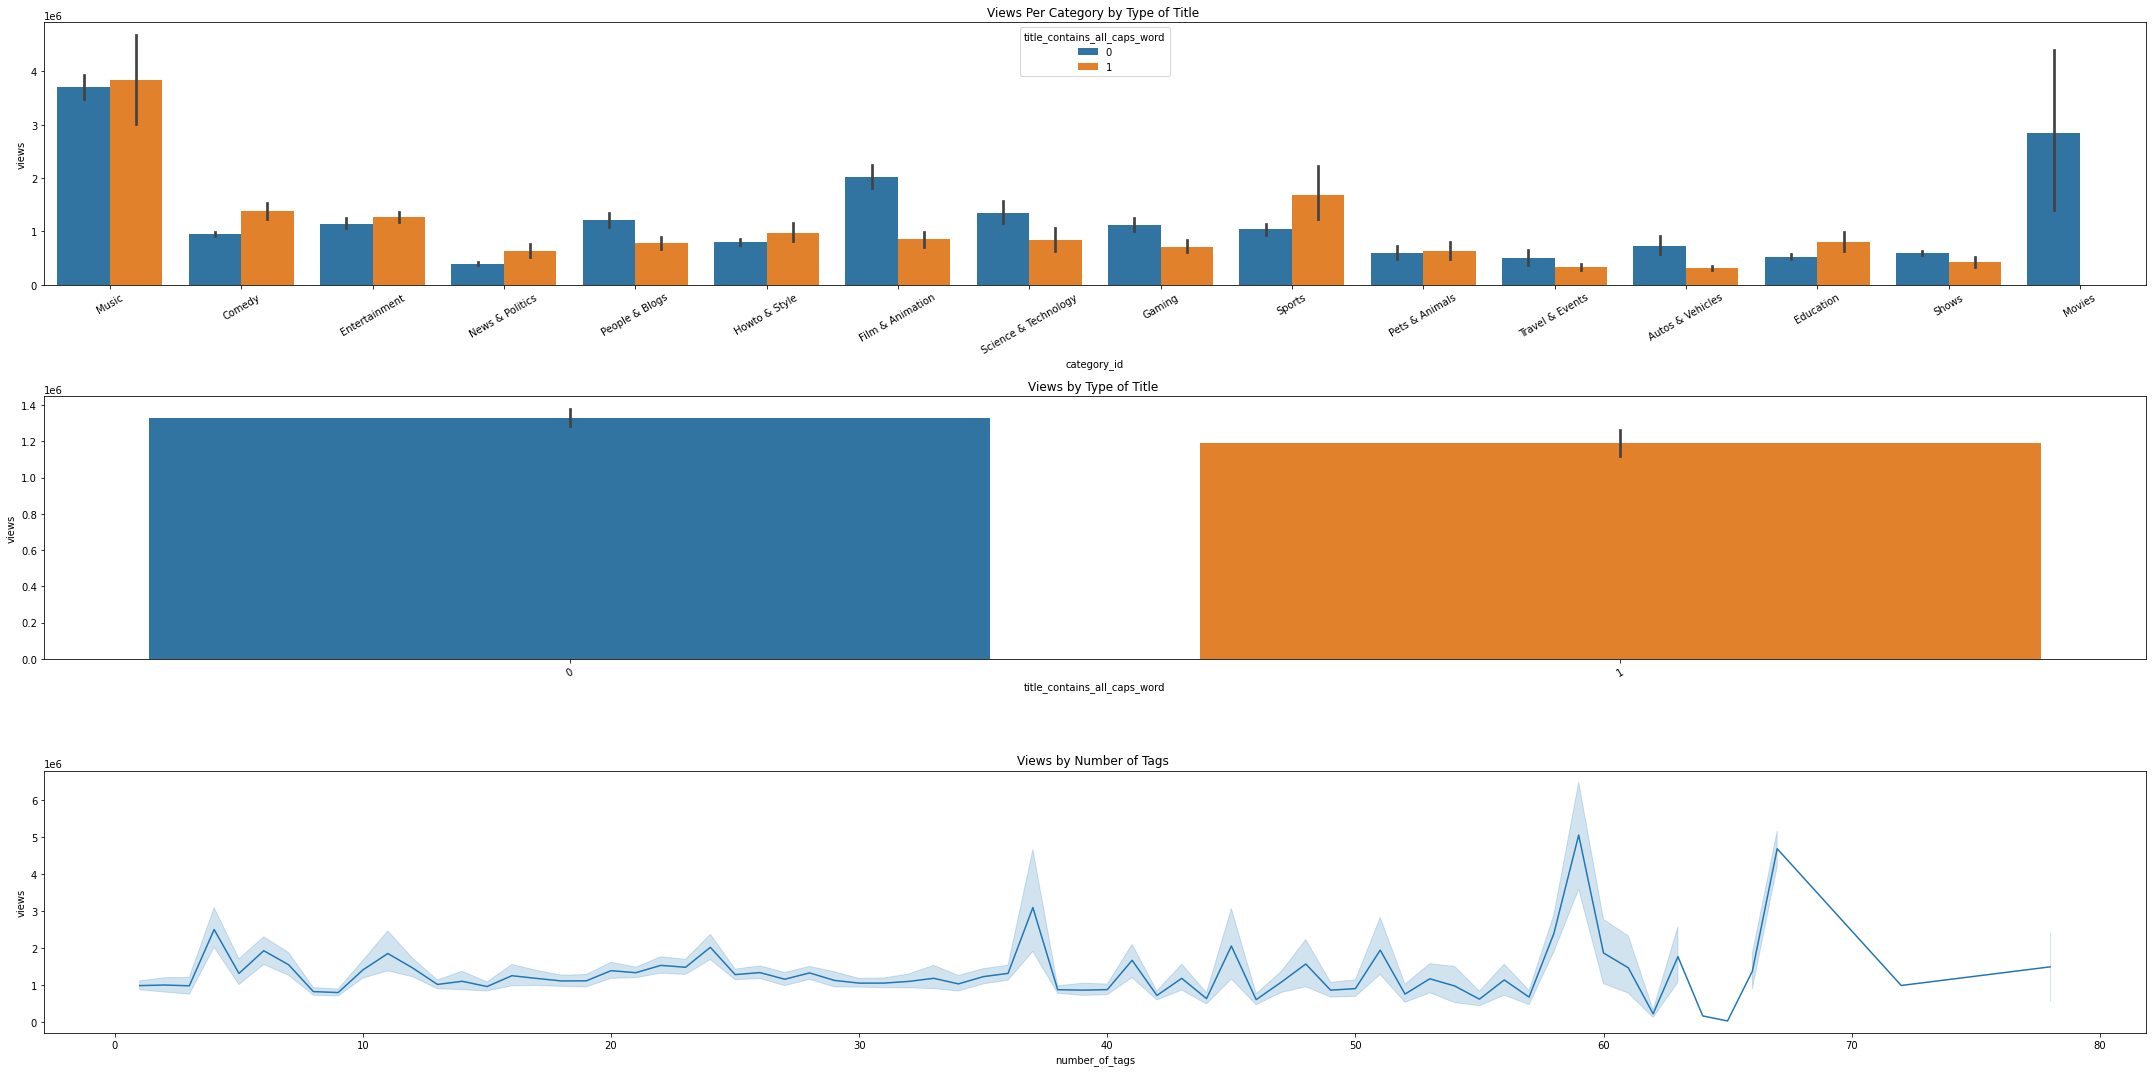

In [43]:
f, ax = plt.subplots(3,1,figsize=(30,15))
category_feeling_barplot = sns.barplot(x=ca_data['category_id'], y=ca_data['views'], hue=ca_data['title_contains_all_caps_word'], ax=ax[0])
category_feeling_barplot.set_xticklabels(feeling_barplot.get_xticklabels(),rotation=30)
category_feeling_barplot.set_title('Views Per Category by Type of Title ')
feeling_barplot = sns.barplot(x=ca_data['title_contains_all_caps_word'], y=ca_data['views'], ax=ax[1])
feeling_barplot.set_xticklabels(feeling_barplot.get_xticklabels(),rotation=30)
feeling_barplot.set_title('Views by Type of Title ')
number_of_tags_plot = sns.lineplot(x=ca_data['number_of_tags'], y=ca_data['views'], ax=ax[2])
number_of_tags_plot.set_title('Views by Number of Tags ')
plt.tight_layout()

# Observations from our Exploratory Data Analysis

Here are some observations from our exploration that will inform the way we build our model:
1. Movies and Music historically get ma higher number of views than other categories. Including category as a predictor is a good idea 
2. Likes and Comment count are highly correlated. Since linear regression assumes multicolinearity it could be a good idea to remove one of them
3. The standard deviation on month 10 is quite high so it's unreasonable to draw an assumption that there is any statistical significance to videos published in this month getting many views
4. Over the few months the trending data was collected, we saw a high amount of views for videos published at 10 AM. There is little standard deviation on this high figure. This relationship with our target variable may mean we can use publish hour as a predictor
5. There is a relationship between likes and categories. Does that mean that one must be removed since we're assuming independance?
6. The title length and number of tags have a very low correlation with our target variable so it might not be worth including for our model

# Considerations

1. Theres a concept in machine learning called data leakage. There are two types: leaky predictors and leaky validation.
> Leaky predictors happen when your predictors include data that will not be available at the time you make predictions.

In our case, we are using likes and comment counts to predict views but what if the video has a high amount of views or a high amount of comments *because* the video has a high amount of views

2. If a product manager or a marketing manager came to us wanting to know how many views their video will get, they will not have certain information that is available within our dataset. This is the information that we should not include in a model used for this purpose:
* likes
* dislikes
* comment count
* video_error_or_removed
* Any feature engineered from these


In [44]:
columns_to_drop = ['video_id', 'trending_date', 'title', 'channel_title','publish_time', 'tags', 'dislikes', 'comment_count', 'thumbnail_link', 'description',
                   'channel_category_name', 'country', 'more_likes', 'like_percentage', 'dislike_percentage']
ca_data = ca_data.drop(columns_to_drop, axis=1)

In [45]:
ca_data.info()
categorical_columns = ['category_id', 'channel_category_id']
categorical_pipeline = Pipeline(steps=[('encoder',OneHotEncoder(handle_unknown='ignore'))])
numerical_columns = ['followers', 'videos', 'title_length', 'number_of_tags']
numerical_pipeline = Pipeline(steps=[('scaler', StandardScaler())])
column_transformer = ColumnTransformer(transformers=[('cat',categorical_pipeline, categorical_columns),('num', numerical_pipeline, numerical_columns)])
model = Pipeline(steps=[('proprocessing', column_transformer),('model', LinearRegression())])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30791 entries, 0 to 41651
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   category_id                   30791 non-null  object 
 1   views                         30791 non-null  int64  
 2   likes                         30791 non-null  int64  
 3   comments_disabled             30791 non-null  bool   
 4   ratings_disabled              30791 non-null  bool   
 5   video_error_or_removed        30791 non-null  bool   
 6   channel_category_id           30791 non-null  float64
 7   followers                     30791 non-null  float64
 8   videos                        30791 non-null  float64
 9   publish_month                 30791 non-null  int64  
 10  publish_hour                  30791 non-null  int64  
 11  title_length                  30791 non-null  int64  
 12  number_of_tags                30791 non-null  int64  
 13  t

In [46]:
Y = ca_data[['views']]
X = ca_data[ca_data.columns.difference(['views'])]
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)


In [47]:
model.fit(x_train, y_train)
predictions = model.predict(x_test)

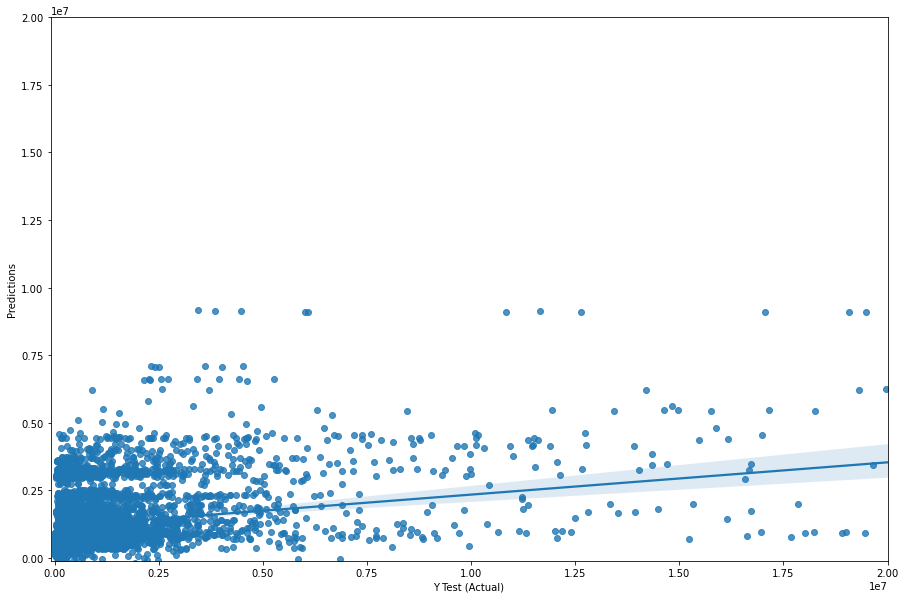

In [48]:
plt.figure(figsize=(15,10))
g = sns.regplot(y_test,predictions,fit_reg=True)
plt.xlabel('Y Test (Actual)')
plt.ylabel('Predictions')
g.set(xlim=(-100000,20000000),ylim=(-100000,20000000))
plt.show(g)

In [49]:
print('MAE :',metrics.mean_absolute_error(y_test,predictions))
print('MSE :',metrics.mean_squared_error(y_test,predictions))
print('RMSE :',np.sqrt(metrics.mean_squared_error(y_test,predictions)))

MAE : 1232933.63915261
MSE : 9395961502239.482
RMSE : 3065283.2662316025


In [50]:
Y = ca_data[['likes']]
X = ca_data[ca_data.columns.difference(['likes', 'views'])]
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
model.fit(x_train, y_train)
predictions = model.predict(x_test)